### Train a 1D CNN model to classify the synthetic ECG data and test the model on real data 

In [1]:
from synDataLoader import syn_mitbih, mixed_mitbih
from DataLoader import mitbih_train, mitbih_test, DataProcessor

In [2]:
data_processor = DataProcessor()
X_train, X_test, y_train, y_test, label_mapping = data_processor.load_and_process_data()

Loaded data shape: (1856443, 3, 150)
Loaded labels shape: (1856443,)
Labels:  ['bicycling' 'household-chores' 'manual-work' 'mixed-activity' 'sitting'
 'sleep' 'sports' 'standing' 'vehicle' 'walking']
Counts:  [ 18079 130622  20286  78060 664344 680313  10597  61249  69860 123033]
Amount of Labels is:  10
Label Mapping: {'bicycling': 0, 'household-chores': 1, 'manual-work': 2, 'mixed-activity': 3, 'sitting': 4, 'sleep': 5, 'sports': 6, 'standing': 7, 'vehicle': 8, 'walking': 9}
Training data shape: (1485154, 3, 150)
Testing data shape: (371289, 3, 150)
Training labels shape: (1485154,)
Testing labels shape: (371289,)


In [3]:
mixed_ecg = mixed_mitbih(X_train, y_train, real_samples = 200, syn_samples = 800)

data shape is (8000, 3, 150)
labels shape is (8000,)
The dataset includes 800 samples of class 0
The dataset includes 800 samples of class 1
The dataset includes 800 samples of class 2
The dataset includes 800 samples of class 3
The dataset includes 800 samples of class 4
The dataset includes 800 samples of class 5
The dataset includes 800 samples of class 6
The dataset includes 800 samples of class 7
The dataset includes 800 samples of class 8
The dataset includes 800 samples of class 9
X_train shape is (2000, 3, 150)
y_train shape is (2000,)
The dataset includes 200 samples of class 0
The dataset includes 200 samples of class 1
The dataset includes 200 samples of class 2
The dataset includes 200 samples of class 3
The dataset includes 200 samples of class 4
The dataset includes 200 samples of class 5
The dataset includes 200 samples of class 6
The dataset includes 200 samples of class 7
The dataset includes 200 samples of class 8
The dataset includes 200 samples of class 9
data shape

In [4]:
syn_ecg = syn_mitbih(n_samples=800, reshape=True)

data shape is (8000, 3, 150)
labels shape is (8000,)
The dataset includes 800 samples of class 0
The dataset includes 800 samples of class 1
The dataset includes 800 samples of class 2
The dataset includes 800 samples of class 3
The dataset includes 800 samples of class 4
The dataset includes 800 samples of class 5
The dataset includes 800 samples of class 6
The dataset includes 800 samples of class 7
The dataset includes 800 samples of class 8
The dataset includes 800 samples of class 9


In [5]:
real_ecg = mitbih_train(X_train, y_train, n_samples=200, oneD=True)

X_train shape is (2000, 3, 150)
y_train shape is (2000,)
The dataset includes 200 samples of class 0
The dataset includes 200 samples of class 1
The dataset includes 200 samples of class 2
The dataset includes 200 samples of class 3
The dataset includes 200 samples of class 4
The dataset includes 200 samples of class 5
The dataset includes 200 samples of class 6
The dataset includes 200 samples of class 7
The dataset includes 200 samples of class 8
The dataset includes 200 samples of class 9


In [6]:
real_test_ecg = mitbih_test(X_test, y_test, n_samples=500, oneD=True)

X_test shape is (5000, 3, 150)
y_test shape is (5000,)
The dataset includes 500 samples of class 0
The dataset includes 500 samples of class 1
The dataset includes 500 samples of class 2
The dataset includes 500 samples of class 3
The dataset includes 500 samples of class 4
The dataset includes 500 samples of class 5
The dataset includes 500 samples of class 6
The dataset includes 500 samples of class 7
The dataset includes 500 samples of class 8
The dataset includes 500 samples of class 9


In [7]:
from torch.utils import data
syn_loader = data.DataLoader(syn_ecg, batch_size=32, num_workers=4, shuffle=True)
real_loader = data.DataLoader(real_ecg, batch_size=32, num_workers=4, shuffle=True)
mixed_loader = data.DataLoader(mixed_ecg, batch_size=32, num_workers=4, shuffle=True)
test_real_loader = data.DataLoader(real_test_ecg, batch_size=32, num_workers=4, shuffle=True)

In [25]:
#Define a simple CNN classifier 
import torch
import torch.nn as nn
import torch.nn.functional as F


class ECG_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(3, 64, 6)
        self.conv2 = nn.Conv1d(64, 64, 6)
        self.conv3 = nn.Conv1d(64, 64, 3)
        self.dropout = nn.Dropout(p=0.5) 
        self.pool = nn.MaxPool1d(3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(832, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x
    


    # def forward(self, x):
    #     x = F.relu(self.conv1(x))
    #     print("After conv1:", x.shape)
    #     x = F.relu(self.conv2(x))
    #     print("After conv2:", x.shape)
    #     x = self.dropout(x)
    #     x = self.pool(x)
    #     print("After first pool:", x.shape)
    #     x = F.relu(self.conv2(x))
    #     x = self.pool(x)
    #     print("After second pool:", x.shape)
    #     x = self.flatten(x)
    #     print("After flatten:", x.shape)
    #     x = F.relu(self.fc1(x))
    #     x = self.fc2(x)
    #     return x


In [9]:
def train(model, train_data_loader, test_data_loader, epochs, criterion, optimizer, filename="test_cm"):
    for epoch in range(epochs):  # loop over the dataset multiple times
        model.train()
        total_loss = 0.0
        total = 0
        correct = 0

        for i, data in enumerate(train_data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        epoch_train_loss = total_loss / len(train_data_loader)
        epoch_train_acc = correct / total
        print(f'Epoch {epoch + 1}, train loss = {epoch_train_loss}, train acc = {epoch_train_acc}')

        if (epoch+1) % 5 == 0:
            _eval(model, test_data_loader, criterion, epoch)
#             _eval_single_class(model, test_data_loader, criterion, epoch)
            
    _final_eval(model, test_data_loader, criterion, filename)

    print('Finished Training and testing')

In [10]:
def _eval(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_test_loss = total_loss / len(real_test_loader)
        epoch_test_acc = correct / total
    
    print('=====================================================')
    print(f'Epoch {epoch+1}, test loss = {epoch_test_loss}, test acc = {epoch_test_acc}')
    print('=====================================================')

In [13]:
classes = ['bicycling', 'household-chores', 'manual-work', 'mixed-activity', 'sitting', 'sleep', 'sports', 'standing', 'vehicle', 'walking']
classes_idx = ['1','2','3','4','5','6','7','8','9','10']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

In [15]:
total_pred

{'bicycling': 0,
 'household-chores': 0,
 'manual-work': 0,
 'mixed-activity': 0,
 'sitting': 0,
 'sleep': 0,
 'sports': 0,
 'standing': 0,
 'vehicle': 0,
 'walking': 0}

In [16]:
def _eval_single_class(model, real_test_loader, criterion, epoch):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # print statistics
            total_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

def _final_eval(model, real_test_loader, criterion, filename="test_cm"):
    nb_classes = 5
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')
    target_names = classes
    y_preds = []
    y_trues = []
    with torch.no_grad():
        for i, data in enumerate(real_test_loader):
            inputs, labels = data
            inputs = inputs.double()
            labels = labels.long()
            
            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)

            # Append batch prediction results
            predlist=torch.cat([predlist,predictions.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])
            
            y_preds.append(predictions)
            y_trues.append(labels)
            
    # Confusion matrix
    cm=confusion_matrix(lbllist.numpy(), predlist.numpy())
    print(cm)
    cm_df = pd.DataFrame(cm,
                     index = classes_idx, 
                     columns = classes_idx)
    fig = plt.figure(figsize=(6.5,5))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#     plt.title('ECG classification Accuracy')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout() # keeps labels from being cutoff when saving as pdf
    plt.savefig(f'{filename}.pdf')
    plt.show()
    
    # Per-class accuracy
    class_accuracy = 100*cm.diagonal() / cm.sum(1)
    print(class_accuracy)
    
    #print classification report 
    y_preds_flatten = [label for sublist in y_preds for label in sublist]
    y_trues_flatten = [label for sublist in y_trues for label in sublist]
    
    print(classification_report(y_trues_flatten, y_preds_flatten, target_names=classes))

Epoch 1, train loss = 2.2944037541397795, train acc = 0.125875
Epoch 2, train loss = 2.2332198353562736, train acc = 0.215
Epoch 3, train loss = 1.9298246356248132, train acc = 0.300375
Epoch 4, train loss = 1.5480783375625764, train acc = 0.399375
Epoch 5, train loss = 1.4504615488995896, train acc = 0.425375
Epoch 5, test loss = 2.891578948913595, test acc = 0.1622
Epoch 6, train loss = 1.411828974233424, train acc = 0.446125
Epoch 7, train loss = 1.3640510518621056, train acc = 0.462375
Epoch 8, train loss = 1.3215546808984326, train acc = 0.476375
Epoch 9, train loss = 1.27142769168496, train acc = 0.49
Epoch 10, train loss = 1.2270120853202646, train acc = 0.512875
Epoch 10, test loss = 3.332275575027459, test acc = 0.1716
Epoch 11, train loss = 1.183924382635167, train acc = 0.531
Epoch 12, train loss = 1.138578118072576, train acc = 0.55175
Epoch 13, train loss = 1.1059670792564487, train acc = 0.56475
Epoch 14, train loss = 1.0593904036305006, train acc = 0.58525
Epoch 15, trai

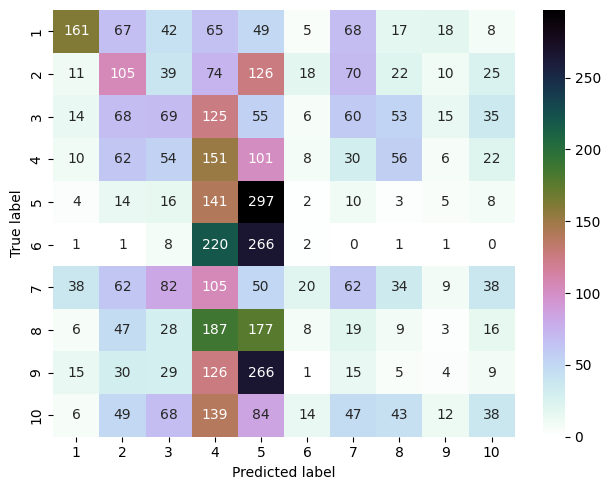

[32.2 21.  13.8 30.2 59.4  0.4 12.4  1.8  0.8  7.6]
                  precision    recall  f1-score   support

       bicycling       0.61      0.32      0.42       500
household-chores       0.21      0.21      0.21       500
     manual-work       0.16      0.14      0.15       500
  mixed-activity       0.11      0.30      0.16       500
         sitting       0.20      0.59      0.30       500
           sleep       0.02      0.00      0.01       500
          sports       0.16      0.12      0.14       500
        standing       0.04      0.02      0.02       500
         vehicle       0.05      0.01      0.01       500
         walking       0.19      0.08      0.11       500

        accuracy                           0.18      5000
       macro avg       0.17      0.18      0.15      5000
    weighted avg       0.17      0.18      0.15      5000

Finished Training and testing


In [26]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, syn_loader, test_real_loader, 50, criterion, optimizer, filename='synthetic_data')

Epoch 1, train loss = 2.303012502815954, train acc = 0.1185
Epoch 2, train loss = 2.3016153012206706, train acc = 0.117
Epoch 3, train loss = 2.299181617981999, train acc = 0.118
Epoch 4, train loss = 2.2974890130101513, train acc = 0.1175
Epoch 5, train loss = 2.2958028459394, train acc = 0.1295
Epoch 5, test loss = 2.2987945904347518, test acc = 0.1366
Epoch 6, train loss = 2.293118249130391, train acc = 0.1515
Epoch 7, train loss = 2.2908607624981396, train acc = 0.154
Epoch 8, train loss = 2.2877198743835967, train acc = 0.1605
Epoch 9, train loss = 2.2839803995822, train acc = 0.1655
Epoch 10, train loss = 2.279492538938431, train acc = 0.172
Epoch 10, test loss = 2.288332685871976, test acc = 0.1722
Epoch 11, train loss = 2.2746880811142467, train acc = 0.1645
Epoch 12, train loss = 2.2686533323591407, train acc = 0.175
Epoch 13, train loss = 2.2609799020284527, train acc = 0.175
Epoch 14, train loss = 2.2523966493969323, train acc = 0.1785
Epoch 15, train loss = 2.24450234154676

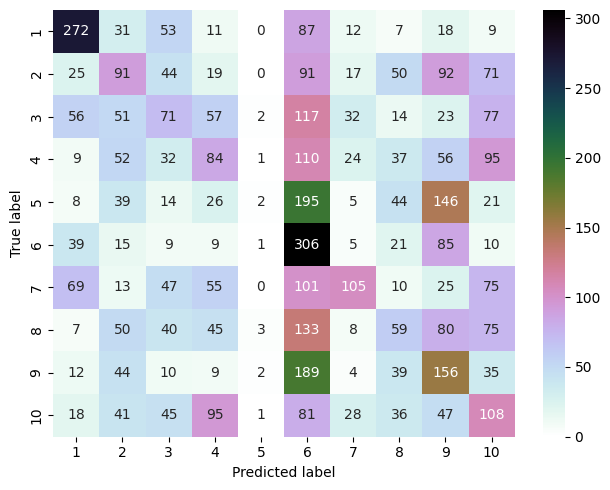

[54.4 18.2 14.2 16.8  0.4 61.2 21.  11.8 31.2 21.6]
                  precision    recall  f1-score   support

       bicycling       0.53      0.54      0.54       500
household-chores       0.21      0.18      0.20       500
     manual-work       0.19      0.14      0.16       500
  mixed-activity       0.20      0.17      0.18       500
         sitting       0.17      0.00      0.01       500
           sleep       0.22      0.61      0.32       500
          sports       0.44      0.21      0.28       500
        standing       0.19      0.12      0.14       500
         vehicle       0.21      0.31      0.25       500
         walking       0.19      0.22      0.20       500

        accuracy                           0.25      5000
       macro avg       0.25      0.25      0.23      5000
    weighted avg       0.25      0.25      0.23      5000

Finished Training and testing


In [27]:
# Define training hyperparameters
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, real_loader, test_real_loader, 50, criterion, optimizer, filename='real_data')

In [29]:
# # Define training hyperparameters
# import torch.optim as optim
# ECG_model = ECG_Net()
# ECG_model.double()
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
# train(ECG_model, real_loader, test_real_loader, 50, criterion, optimizer, filename='real_data_small')

Epoch 1, train loss = 2.2866356726704646, train acc = 0.2047
Epoch 2, train loss = 2.148692451092016, train acc = 0.2891
Epoch 3, train loss = 1.8505994268616088, train acc = 0.3457
Epoch 4, train loss = 1.7795564661413619, train acc = 0.3678
Epoch 5, train loss = 1.7475690015239398, train acc = 0.3771
Epoch 5, test loss = 2.3458257803341147, test acc = 0.1702
Epoch 6, train loss = 1.7175753950735462, train acc = 0.3811
Epoch 7, train loss = 1.6867592488770626, train acc = 0.3987
Epoch 8, train loss = 1.657817317430492, train acc = 0.4079
Epoch 9, train loss = 1.628013142652907, train acc = 0.4231
Epoch 10, train loss = 1.603683843777204, train acc = 0.4391
Epoch 10, test loss = 2.30172573973186, test acc = 0.1834
Epoch 11, train loss = 1.5698887880765342, train acc = 0.454
Epoch 12, train loss = 1.539156521535573, train acc = 0.4671
Epoch 13, train loss = 1.5050784798561574, train acc = 0.4828
Epoch 14, train loss = 1.4787235372665424, train acc = 0.4946
Epoch 15, train loss = 1.44437

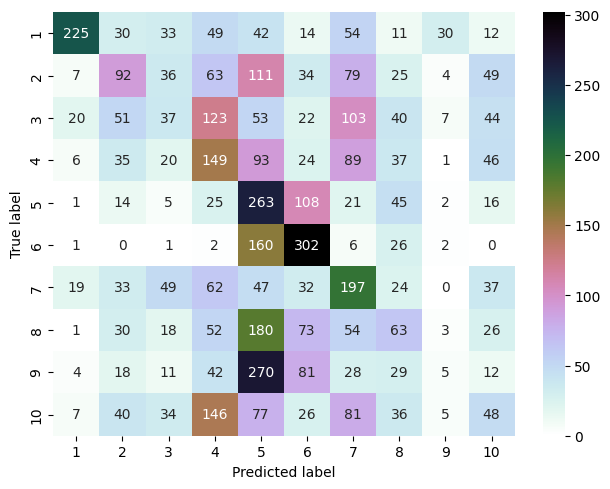

[45.  18.4  7.4 29.8 52.6 60.4 39.4 12.6  1.   9.6]
                  precision    recall  f1-score   support

       bicycling       0.77      0.45      0.57       500
household-chores       0.27      0.18      0.22       500
     manual-work       0.15      0.07      0.10       500
  mixed-activity       0.21      0.30      0.25       500
         sitting       0.20      0.53      0.29       500
           sleep       0.42      0.60      0.50       500
          sports       0.28      0.39      0.33       500
        standing       0.19      0.13      0.15       500
         vehicle       0.08      0.01      0.02       500
         walking       0.17      0.10      0.12       500

        accuracy                           0.28      5000
       macro avg       0.27      0.28      0.25      5000
    weighted avg       0.27      0.28      0.25      5000

Finished Training and testing


In [28]:
import torch.optim as optim
ECG_model = ECG_Net()
ECG_model.double()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(ECG_model.parameters(), lr=0.0005, momentum=0.9)
train(ECG_model, mixed_loader, test_real_loader, 50, criterion, optimizer, filename='mixed_data')